In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
Lx = 0 # boundary 
Rx = 1 # boundary
x_list = np.linspace(Lx, Rx, 100)

def exact_u(f, x):
    """
        The exact solution for 1D case.
        
        See the fomula in Eq (3.3) in textbook
        
        f is the above function in the PDE
        x is a single number for input
        x cannot take a vector as values, in this implementation.
    """
    
    v1 = x * scipy.integrate.quad(lambda s : f(s)*(1-s), 0, 1)[0]
    v2 = scipy.integrate.quad(lambda s : f(s)*(x-s), 0, x)[0]
    return v1 - v2

### The goal is to demonstrate 1D FEM
We use the following example:
$$-u''(x) = f(x), \qquad u(0) = u(1) = 0$$
on the domain $[0,1]$.

### Pick $f$

In [3]:
#f = lambda x : x*(1-x)*(1/3 - np.abs(np.cos(2*np.pi*2*(x-1/3))))
f = lambda x : 2*np.pi*np.sin(2*np.pi*x)

### We use $\mathbb{P}_1$ FEM

In [4]:
φ = lambda x : np.maximum(0, 1-np.abs(x))

def ϕ_ln(h, shift):
    # basis functions
    return lambda x : φ((x-shift)/h)

def FEM_1D_linear(M, f, x_list, approx_b=True):
    
    h = 1/M
    x_grid = np.array(np.arange(M+1)) * h
    ϕlist = [ϕ_ln(h, x_grid[j]) for j in range(1, M)]

    A = (np.diag((-1)*np.ones(M-2),k=1) + np.diag((-1)*np.ones(M-2),k=-1) + np.diag(2*np.ones(M-1)))/h

    b = np.zeros(M-1)
    if approx_b == True:
        for j in range(M-1):
            b[j] = f(x_grid[j+1])*h
    else:
        for j in range(M-1):
            b[j] = scipy.integrate.quad(lambda x : (ϕlist[j])(x)*f(x), Lx, Rx)[0]

    c = np.linalg.solve(A, b)
    
    y_list = np.zeros(len(x_list))
    for j in range(len(x_list)):
        x = x_list[j]
        for k in range(M-1):
            y_list[j] += c[k] * (ϕlist[k])(x)

    return y_list, c, A, b

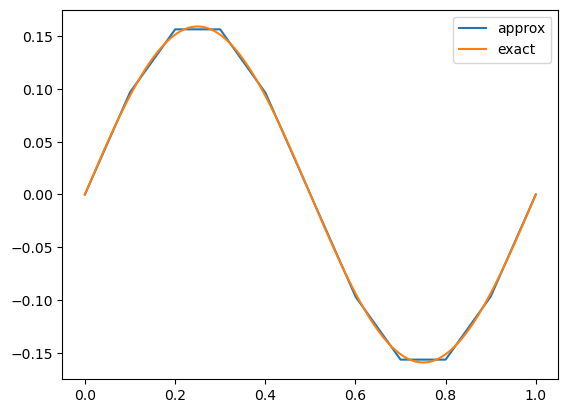

In [5]:
x_list = np.linspace(Lx, Rx, 1000)
M = 10
plt.plot(x_list, FEM_1D_linear(M, f, x_list)[0], label="approx")
exact_u_values = np.array([exact_u(f, item) for item in x_list])
plt.plot(x_list, exact_u_values, label="exact")
plt.legend()
plt.show()

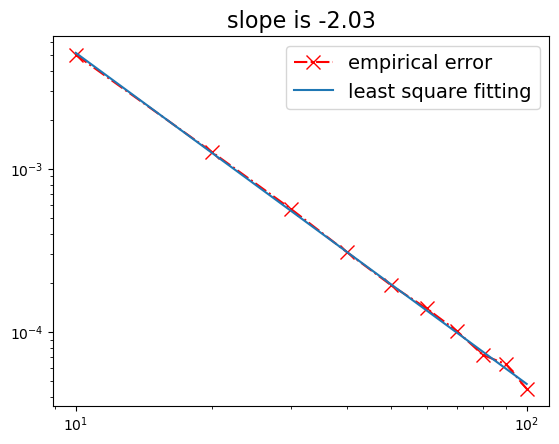

In [6]:
M_list = np.ceil(np.linspace(10, 100, 10))
M_list = [int(item) for item in M_list]

err = [np.max(np.abs(FEM_1D_linear(M_list[j], f, x_list)[0] - exact_u_values)) for j in range(len(M_list))]
plt.plot(M_list, err, 'rx-.', label="empirical error", markersize=10)

X = np.log10(M_list)
X = np.vstack([X, np.ones(len(X))]).T
m, c = np.linalg.lstsq(X, np.log10(err), rcond=None)[0]
plt.plot(M_list, 10**(m * np.log10(M_list) + c), label="least square fitting")

plt.xscale('log')
plt.yscale('log')
plt.title("slope is {:.2f}".format(m), fontsize=16)
plt.legend(fontsize=14)
plt.show()

### We use $\mathbb{P}_2$ FEM

In [7]:
def FEM_Quad_Approx(n_elements):
    """
        written by GPT-4 with minor modification.
    """
    
    alpha = 0.0  # Boundary condition at x = 0
    beta = 0.0   # Boundary condition at x = 1

    # Number of elements and nodes
    #n_elements = 10
    n_nodes = 2 * n_elements + 1

    # Mesh generation (equally spaced nodes)
    L = 1.0
    x = np.linspace(0, L, n_nodes)

    # Element size
    h = L / n_elements

    # Stiffness matrix and load vector initialization
    K = np.zeros((n_nodes, n_nodes))
    b = np.zeros(n_nodes)

    # Assembly of the stiffness matrix and load vector
    for e in range(n_elements):
        # Local to global mapping
        i0 = 2 * e
        i1 = 2 * e + 1
        i2 = 2 * e + 2

        # Stiffness matrix for quadratic element in 1D: integral(phi_i' * phi_j') over the element
        Ke = (1 / (3 * h)) * np.array([[7, -8, 1],
                                       [-8, 16, -8],
                                       [1, -8, 7]])

        # Load vector for quadratic element in 1D: integral(f * phi_i) over the element
        fe = (h / 6) * np.array([f(x[i0]), 4 * f(x[i1]), f(x[i2])])

        # Global assembly
        K[i0:i2+1, i0:i2+1] += Ke
        b[i0:i2+1] += fe

    # Apply Dirichlet boundary conditions
    K[0, :], K[-1, :] = 0, 0  # Zero out the first and last row
    K[0, 0], K[-1, -1] = 1, 1  # Put a 1 on the diagonal
    b[0], b[-1] = alpha, beta  # Set the first and last entry of the load vector

    # Solve the system of linear equations
    u = np.linalg.solve(K, b)
    
    exact_u_values = np.array([exact_u(f, item) for item in x])

    return x,  u, exact_u_values, np.max(np.abs(exact_u_values - u))

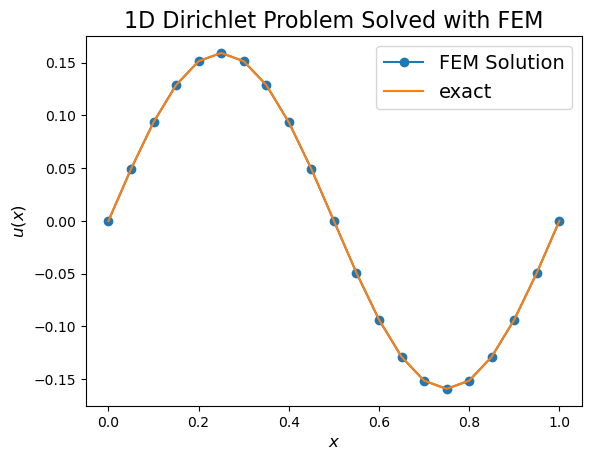

In [8]:
x, u, exact_u_values_2, _ = FEM_Quad_Approx(10)
plt.plot(x, u, '-o', label='FEM Solution')
plt.plot(x, exact_u_values_2, label="exact")
plt.xlabel(r'$x$', fontsize=12)
plt.ylabel(r'$u(x)$', fontsize=12)
plt.title('1D Dirichlet Problem Solved with FEM',fontsize=16)
plt.legend(fontsize=14)
plt.show()

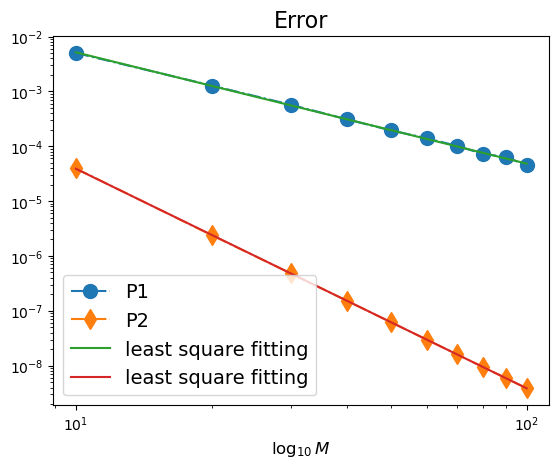

In [9]:
err_2 = np.zeros(len(M_list))
for j in range(len(M_list)):
    _, _, _, err_2[j] = FEM_Quad_Approx(int(M_list[j]))

plt.plot(M_list, err, 'o-.', label="P1", markersize=10)
plt.plot(M_list, err_2, 'd-.', label="P2", markersize=10)
plt.legend()

m, c = np.linalg.lstsq(X, np.log10(err), rcond=None)[0]
plt.plot(M_list, 10**(m * np.log10(M_list) + c), label="least square fitting")

m2, c2 = np.linalg.lstsq(X, np.log10(err_2), rcond=None)[0]
plt.plot(M_list, 10**(m2 * np.log10(M_list) + c2), label="least square fitting")

plt.title('Error', fontsize=16)
plt.xlabel(r'$\log_{10} M$', fontsize=12)
plt.xscale('log'); plt.yscale('log')
plt.legend(fontsize=14)
plt.show()

In [10]:
print("slope of P1 is {:.2f}".format(m))
print("slope of P2 is {:.2f}".format(m2))

slope of P1 is -2.03
slope of P2 is -4.00
